## Setup:

GDAL is required for GeoTIFF files.  If you are not running GeoTIFF files and have issues with GDAL, remove 'gdal' from `setup.py` and comment out references to 'gdal' in the code below.

`pip install -e .` in the parent dir should be sufficient to install this package.  

### GeoTIFF format

    0. \sigma (normalized radar cross section)

    1. incidence angle (with units specified in the `config.yaml` file)

    2. latitude

    3. longitude

## set `wd` to the data directory
This path should contain a file named `config.yaml` which specifies the input, processing and output filenames and parameters for processing the data.  See [`../prototypes/config.yaml`](http://localhost:8888/edit/prototypes/config.yaml) for an example.

In [1]:
wd = '~/OilSpill/Data/SantaBarbara'                   # one UAVSAR (envi) scene
wd = "~/OilSpill/Data/NOAA-Sentinel-Processing-Tests" # one netcdf file
wd = "~/OilSpill/Data/UAVSARdata20230727074139"       # two UAVSAR (envi) scenes
wd = "~/OilSpill/Data/Sentinel-standardized/"         # two geotiff files (masked, unmasked)
wd = "~/OilSpill/Data/NOAA_BigLotTest/"               # one netcdf w/ NOAA output for comparison

## HEADER - must run once to import packages

In [2]:
from matplotlib.pyplot import *
import numpy as np
from numpy import pi
from numpy.polynomial.polynomial import polyval
from os import path, makedirs
from os.path import abspath, basename
from glob import glob
from pprint import pp
from datetime import datetime
from netCDF4 import Dataset as ncfile
import yaml, spectral

import OilClassification.io as io
import OilClassification.util as u
from OilClassification import pkl

from osgeo import gdal

import subprocess
def get_most_recent_git_tag():
    try:
        git_tag = str(
            subprocess.check_output(['git', 'describe', '--abbrev=0', '--tags'], stderr=subprocess.STDOUT)
        ).strip('\'b\\n')
    except subprocess.CalledProcessError as exc_info:
        raise Exception(str(exc_info.output))
    return git_tag

versionLabel = 'JPL' + get_most_recent_git_tag()
print(versionLabel)

JPL0.21


## Read in the `config.yaml` file
See [`../prototypes/config.yaml`](http://localhost:8888/edit/prototypes/config.yaml) for an example.  The link assumes your jupyter session is on http://localhost:8888.  Edit the link if necessary

In [3]:
wd = path.expanduser(wd)
with open(abspath(path.join(wd, 'config.yaml'))) as fh:
    cfg = yaml.safe_load(fh)
cfgIn   = cfg['input']
cfgProc = cfg['process']
cfgOut  = cfg['output']

DataFormat = cfgIn['format'].upper() # ENVI, GEOTIFF, or NETCDF

if cfgIn['indeg']:
    ang2deg = 1
    ang2rad = pi/180
    angLabel = 'deg'
else:
    ang2deg = 180/pi
    ang2rad = 1
    angLabel = 'rad'

## read file list; get maskfile


In [4]:
filelist = np.sort(glob(path.join(wd, cfgIn['infiles'])))
inputDir = path.dirname(filelist[0])

if cfgIn['uselandmask']:
    maskfile = path.join(inputDir, cfgIn['maskfile'] + '.hdr')
    LandMask = spectral.open_image(maskfile)
    landmask = LandMask.read_band(0).astype(bool)
else:
    landmask = False

In [5]:
jj = 0 # Main loop index variable.

# MAIN LOOP
Loops over each entry of `filelist`.  The `for` is suppressed to allow parts of the loop to be chunked.

## Set up output directories

In [6]:
thisfile = filelist[jj]
infile   = path.splitext(path.basename(thisfile))[0]

if DataFormat == 'ENVI':
    hdrfile = path.join(inputDir, thisfile + '.hdr')
    [rootname, product, pol, lineID, fltID, datatake, fltdate] = io.parse_prodname_UAVSAR(thisfile)
    incangfile = path.abspath(path.join(inputDir, rootname + cfgIn['incangsuffix']))
if DataFormat in ['GEOTIFF','NETCDF']:
    product = None

try:
    outdir  = path.join(wd, eval(cfgOut['outdir']))
except:
    outdir  = path.join(wd, cfgOut['outdir'])
makedirs(outdir, exist_ok=True)

### load the main data (`Param`) and incidence angle files
generate maps with and without the land mask

* `param` could be radar cross section or some other derived parameter (from rcs)

image rotation: 0.198834 rad; flip: 1


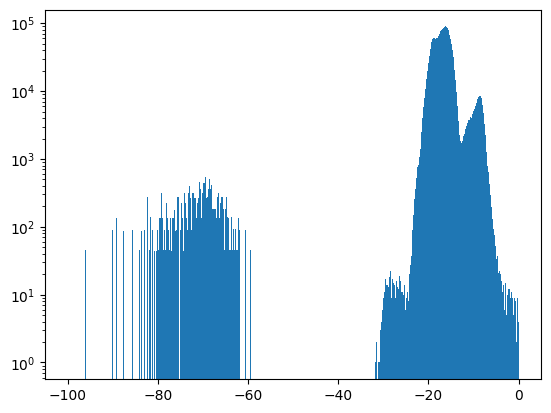

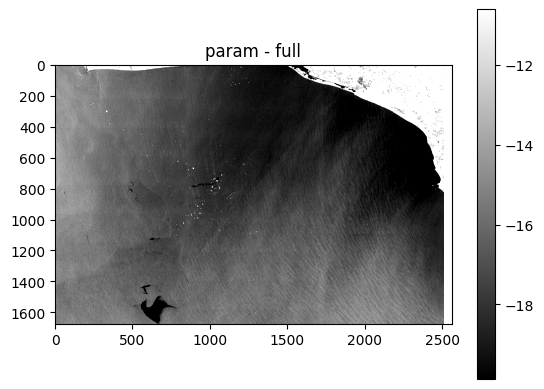

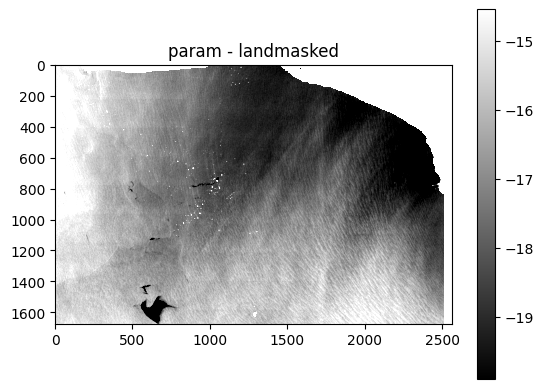

In [7]:
if DataFormat == 'ENVI':
    Param  = spectral.open_image(hdrfile)
    IncAng = spectral.open_image(incangfile + '.hdr')

    param  = np.ma.masked_invalid(Param.read_band(0))
    incang = np.ma.masked_invalid(IncAng.read_band(0))
elif DataFormat == 'GEOTIFF':
    DataSet = gdal.Open(thisfile)
    dataset = DataSet.ReadAsArray().astype(np.double)

    param  = np.ma.masked_invalid(dataset[0])
    incang = np.ma.masked_invalid(dataset[1])
elif DataFormat == 'NETCDF':
    with ncfile(thisfile) as ds:
        param    = ds['sigma'][:].astype(np.double)
        incang   = ds['incid'][:].astype(np.double)
        landmask = ds['mask'][:] > 0
        T = (np.double(ds.ul_outer_lon) + np.double(ds.ur_outer_lon) + 1j*(np.double(ds.ul_outer_lat) + np.double(ds.ur_outer_lat)))/2
        B = (np.double(ds.ll_outer_lon) + np.double(ds.lr_outer_lon) + 1j*(np.double(ds.ll_outer_lat) + np.double(ds.lr_outer_lat)))/2
        L = (np.double(ds.ul_outer_lon) + np.double(ds.ll_outer_lon) + 1j*(np.double(ds.ul_outer_lat) + np.double(ds.ll_outer_lat)))/2
        R = (np.double(ds.ur_outer_lon) + np.double(ds.lr_outer_lon) + 1j*(np.double(ds.ur_outer_lat) + np.double(ds.lr_outer_lat)))/2

        img_rot = np.angle((T-B)*(-1j))
        lr_flip = bool(abs(img_rot - np.angle(L-R)) > pi/2) # doesn't look right, but it works...
        print("image rotation: %f rad; flip: %d"%(img_rot, lr_flip))

# default config assumption is that param is in dB.
if 'indb' in cfgIn and not cfgIn['indb']:
    #param.mask |= param.data <= 0
    param = 10 * np.ma.log10(param)

figure()
hist(param[~param.mask],np.linspace(-100,0,1000));
yscale('log');

# mask out unphysically low values
param.mask |= param < -50

figure()
clims = np.percentile(param.data[~param.mask] , [5, 95])
imshow(param, vmin=clims[0], vmax=clims[1], cmap='gray')
title('param - full')
colorbar()

# mask out land in `param`
param.mask |= landmask

figure()
clims = np.percentile(param.data[~param.mask], [5, 95])
imshow(param, vmin=clims[0], vmax=clims[1], cmap='gray')
title('param - landmasked')
colorbar()

### Generate the angular bins
`incang` is in radians, but angle limits are specified in degrees.

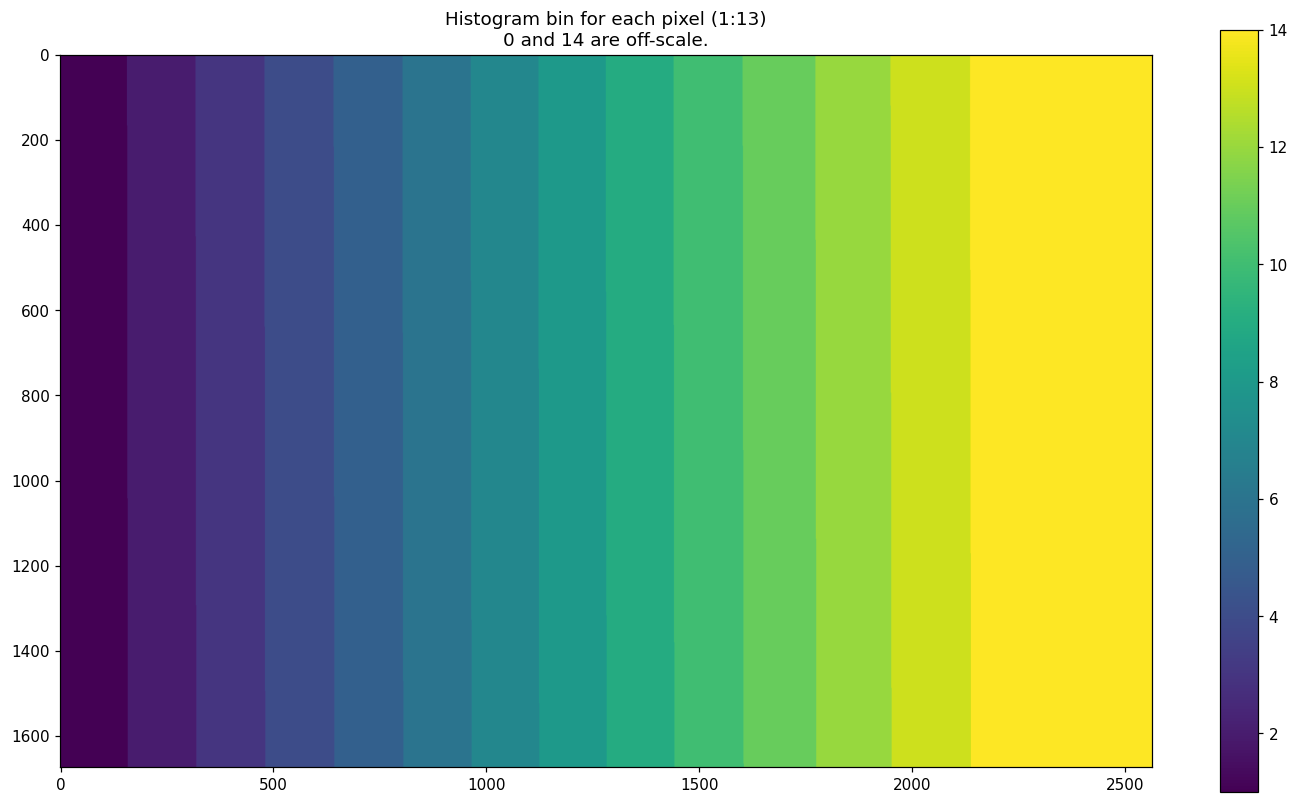

In [8]:
# mask out land in `incang`
incang.mask |= landmask

# generate the angular bins
angmin = np.amin(incang)*ang2deg
angmax = np.amax(incang)*ang2deg
angminb = angmin
if cfgProc['setinclolim']:
    angminb = max(cfgProc['inclolim'], angminb)
angmaxb = angmax
if cfgProc['setinchilim']:
    angmaxb = min(cfgProc['inchilim'], angmaxb)
nAngBins    = max(1, round(angmaxb - angminb))
angbinedges = np.linspace(angminb,angmaxb,nAngBins + 1)
angbinedges = angbinedges.astype(np.double) / ang2deg
# balance the bins to equalize populations
inchist,_ = np.histogram(incang[~incang.mask], angbinedges)
inccumulative = np.concatenate(([0], np.cumsum(inchist)))
angbinedges = np.interp(np.linspace(0, inccumulative[-1], inccumulative.size),
                        inccumulative, angbinedges)

angmap      = np.digitize(incang, angbinedges)

figure(figsize=(16,9),dpi=110)
imshow(angmap)
title('Histogram bin for each pixel (1:%d)\n0 and %d are off-scale.'%(nAngBins,nAngBins+1))
colorbar()

### Find the clean water in the image within each angular bin

Histogramming of the reflected intensity vs incidence angle happens inside `id_pix_as_cleanwater`.

* The smoothing algorithm needs some work -- matlab's `smooth` (not yet adopted here) is visibly more appealing, but may get noisy near the endpoints of the histogram

Text(0.5, 1.0, 'clean mask')

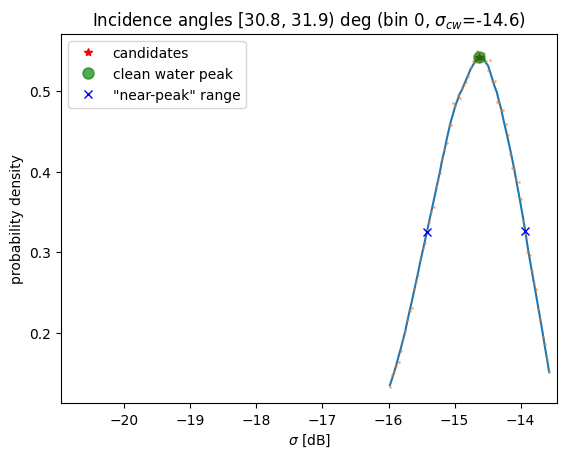

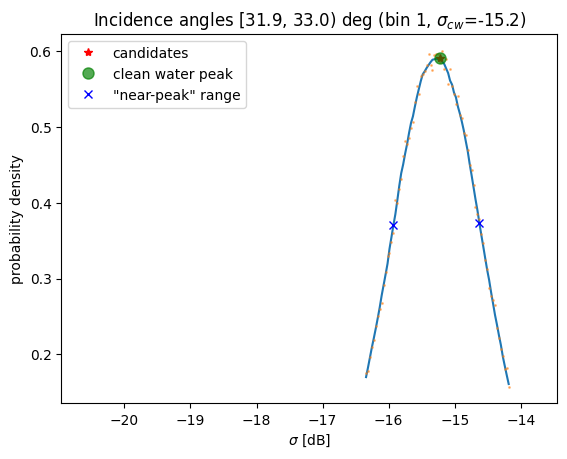

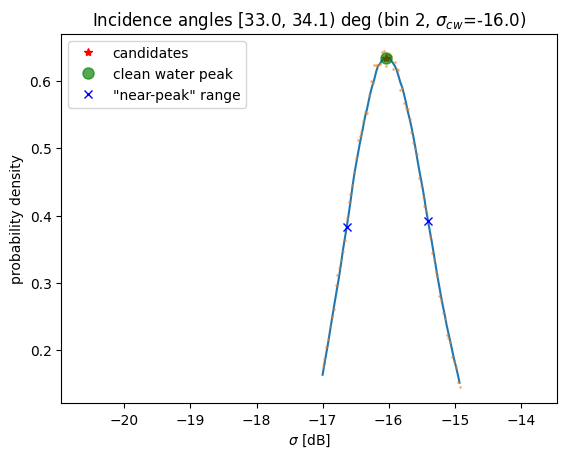

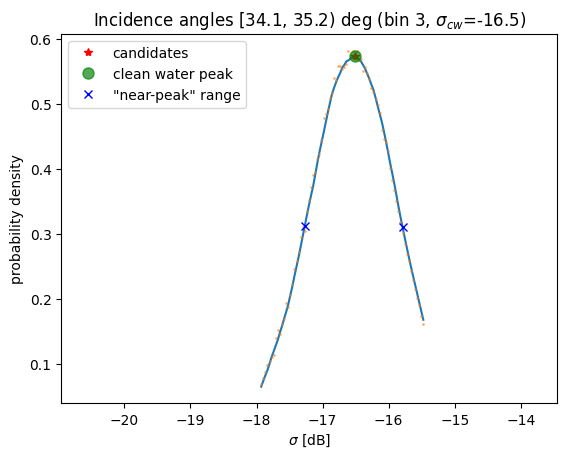

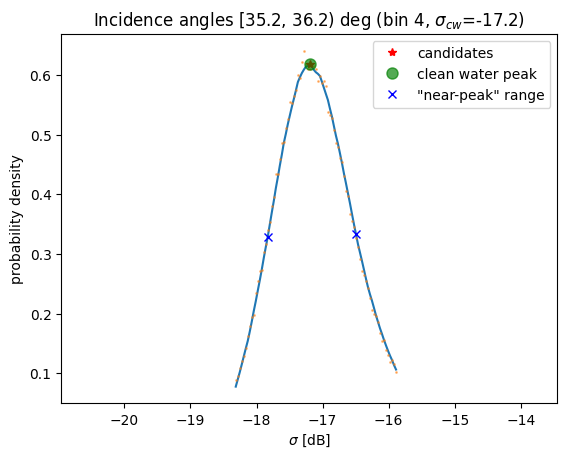

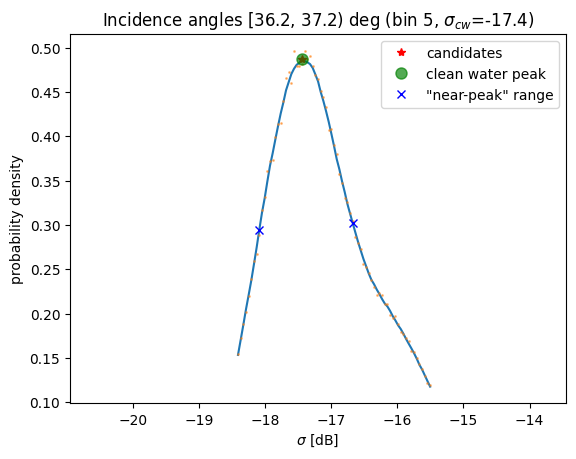

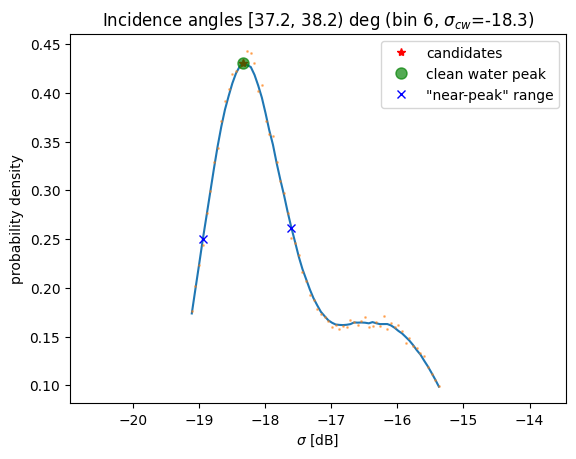

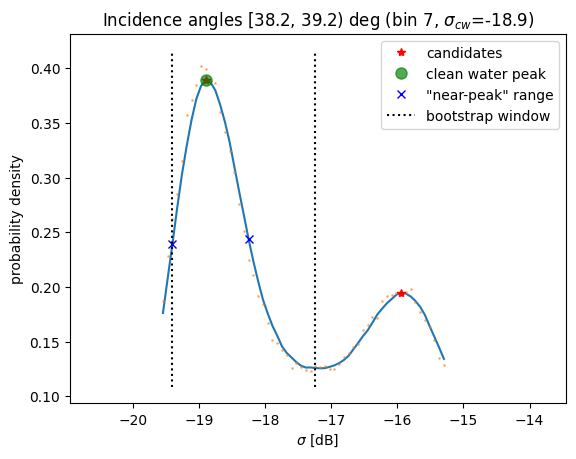

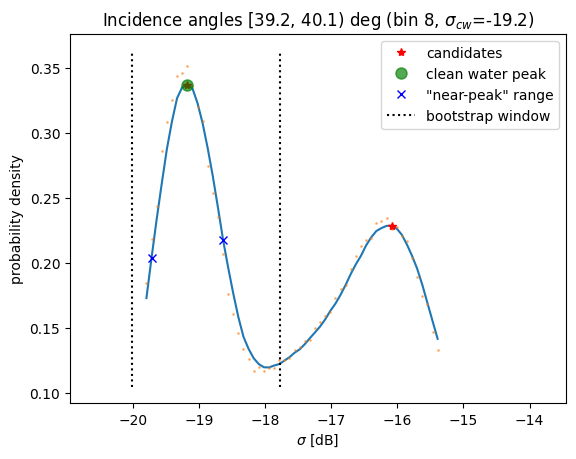

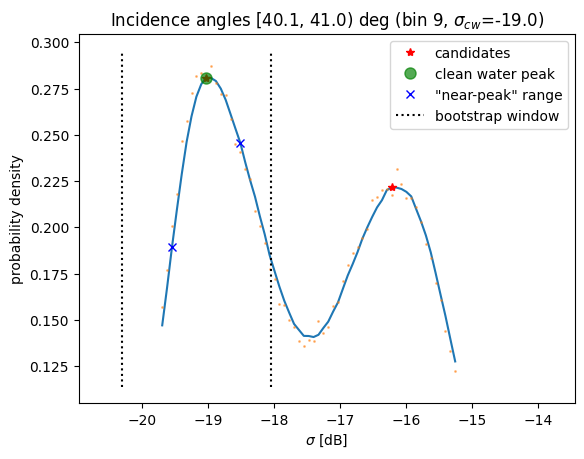

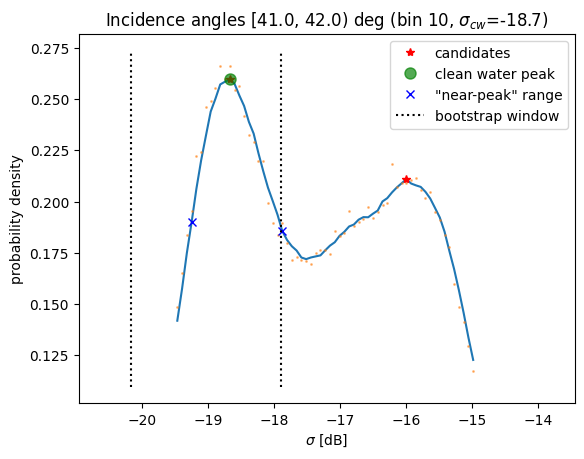

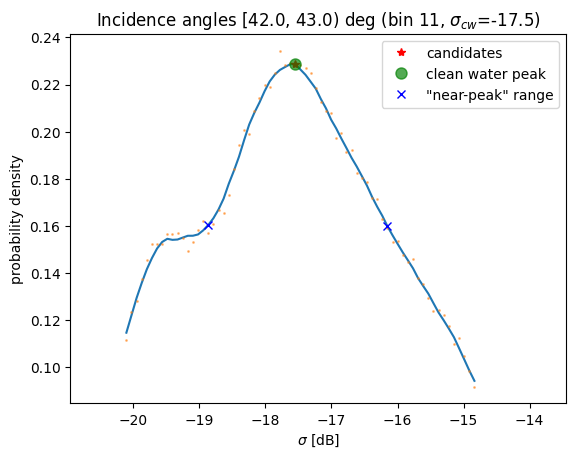

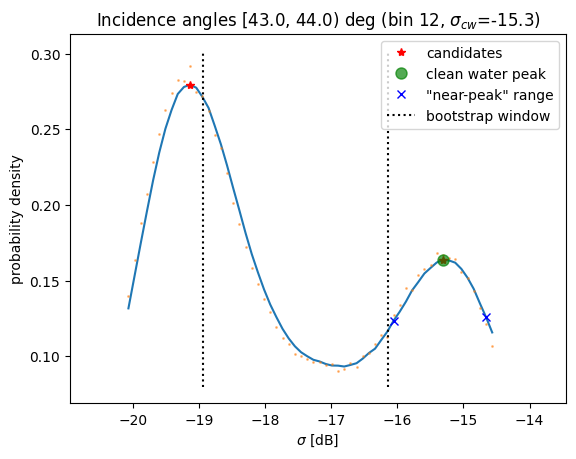

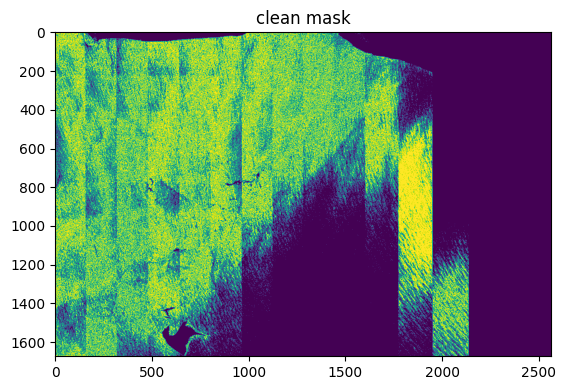

In [9]:
# set up for inner loop
cleanmask  = np.zeros(param.data.shape).astype(bool)
nosolution = np.zeros(nAngBins).astype(bool)

angPopulation = np.histogram(incang, angbinedges)[0]
avgHistPop = np.sum(~incang.mask) / nAngBins

# try to make the xrange of the figures the same.
xlimits = np.percentile(param.data[~param.mask], [1, 99])

lastval = None;
for ii in np.r_[1:nAngBins + 1]:
    thisparam = param.copy()
    thisparam.mask |= (angmap != ii)

    # skip pixels with low-population angle bins
    if np.sum((~thisparam.mask).astype(int)) < 0.001 * avgHistPop:
        param.mask |= (angmap == ii)
        print("skipping bin %d for low population"%ii)
        continue

    clean, nosolution[ii-1], lastval = u.id_pix_as_cleanwater(thisparam, lastval)
    if lastval is not None:
        title('Incidence angles [%.1f, %.1f) deg (bin %d, $\\sigma_{cw}$=%.1f)'%
              (angbinedges[ii-1]*ang2deg, angbinedges[ii]*ang2deg, ii-1, lastval))
    else:
        title('Incidence angles [%.1f, %.1f) deg (bin %d, $\\sigma_{cw}$=None)'%
              (angbinedges[ii-1]*ang2deg, angbinedges[ii]*ang2deg, ii-1))

        
    # extend xlim if needed
    xlimits[0] = min(xlimits[0],xlim()[0])
    xlimits[1] = max(xlimits[1],xlim()[1])
    xlim(xlimits)

    cleanmask |= clean
    if nosolution[ii-1]:
        print("(angle bin %d)."%ii)
    if not cfgProc['bootstrap']:
        lastval = None

if not np.any(cleanmask):
    print('Failed: No clean water pixels identified in file %s.'%thisfile)
    #continue

outsideanglims = np.zeros(incang.shape).astype(bool)
if cfgProc['setinclolim']:
    outsideanglims |= (incang < cfgProc['inclolim'] / ang2deg)
if cfgProc['setinchilim']:
    outsideanglims |= (incang > cfgProc['inchilim'] / ang2deg)

figure()
imshow(cleanmask)
title('clean mask')

### Fit param vs. incang restricting data to clean water
`contrast` holds data to be pickled.  Unlike matlab's `*.mat` files, python's pickle files
can only hold a single variable.
    

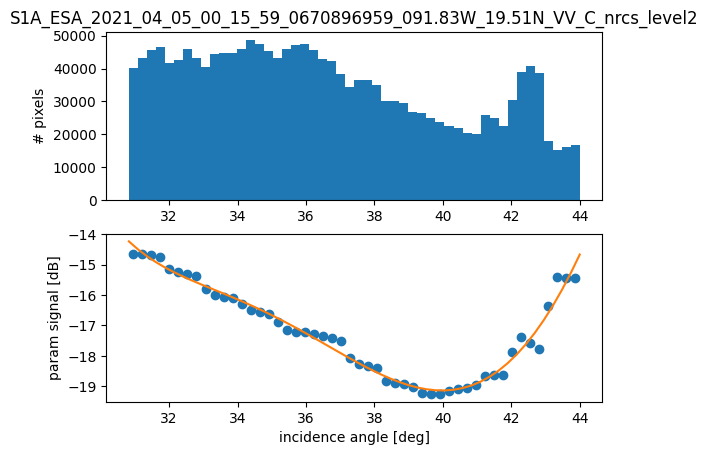

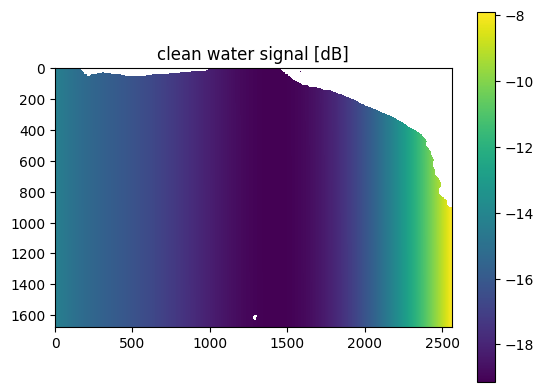

In [10]:
status, wfit, fittype, nfitbins = u.fit_xy_from_AOImask(incang, param, cleanmask,
                                                        Xlabel= f'incidence angle [{angLabel}]',
                                                        Ylabel= 'param signal [dB]',
                                                        Title = infile)
cleanwaterfit = polyval(incang, wfit)
figure()
imshow(cleanwaterfit)
title('clean water signal [dB]')
colorbar()

### Collect files over which to calculate damping ratio

In [11]:
if DataFormat == 'ENVI':
    FilesToProcess = []
    for ftype in cfgProc['filetype']:
        namestr = f'*{lineID}*{fltID}*{datatake}*{ftype}'
        FilesToProcess = list(np.concatenate((FilesToProcess, glob(path.join(inputDir,namestr)))))
    for pattern in cfgProc['exclude']:
        FilesToProcess = [f for f in FilesToProcess if pattern not in f]
    cfgOut['interleave'] = Param.metadata['interleave']
    cfgOut['metadata']   = Param.metadata
elif DataFormat in ['GEOTIFF','NETCDF']:
    FilesToProcess = [thisfile]
    if cfgOut['format'].upper() == 'ENVI':
        if cfgIn['uselandmask']:
            cfgOut['interleave'] = LandMask.metadata['interleave']
            cfgOut['metadata']   = LandMask.metadata
        else:
            cfgOut['interleave'] = "bip" # default if not specified
            cfgOut['metadata']   = ()

### Calculate contrast for each valid filetype

* Assign `amp` according to data format
* Generate figures
* Write results to corresponding outfile.

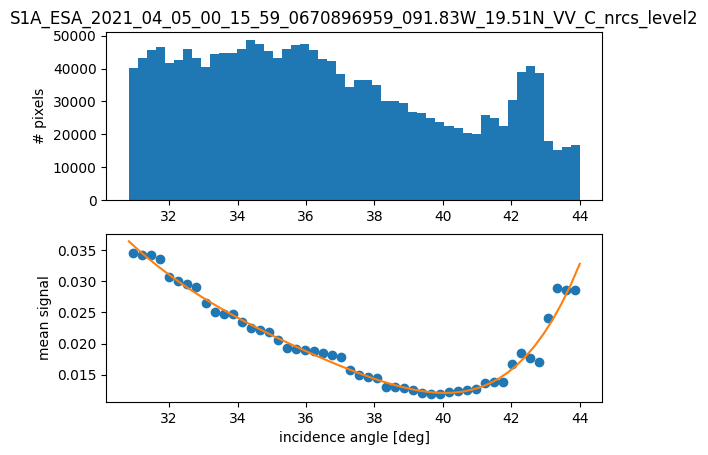

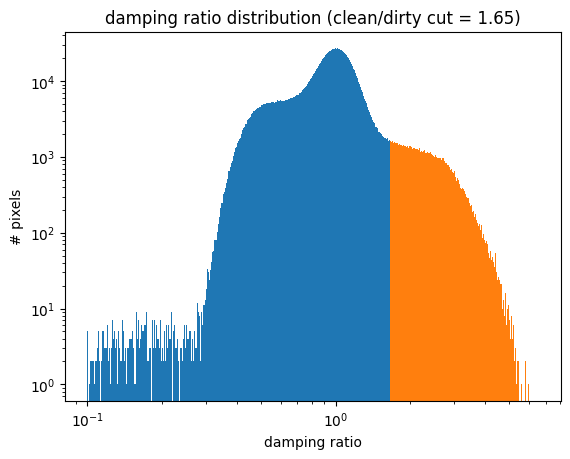

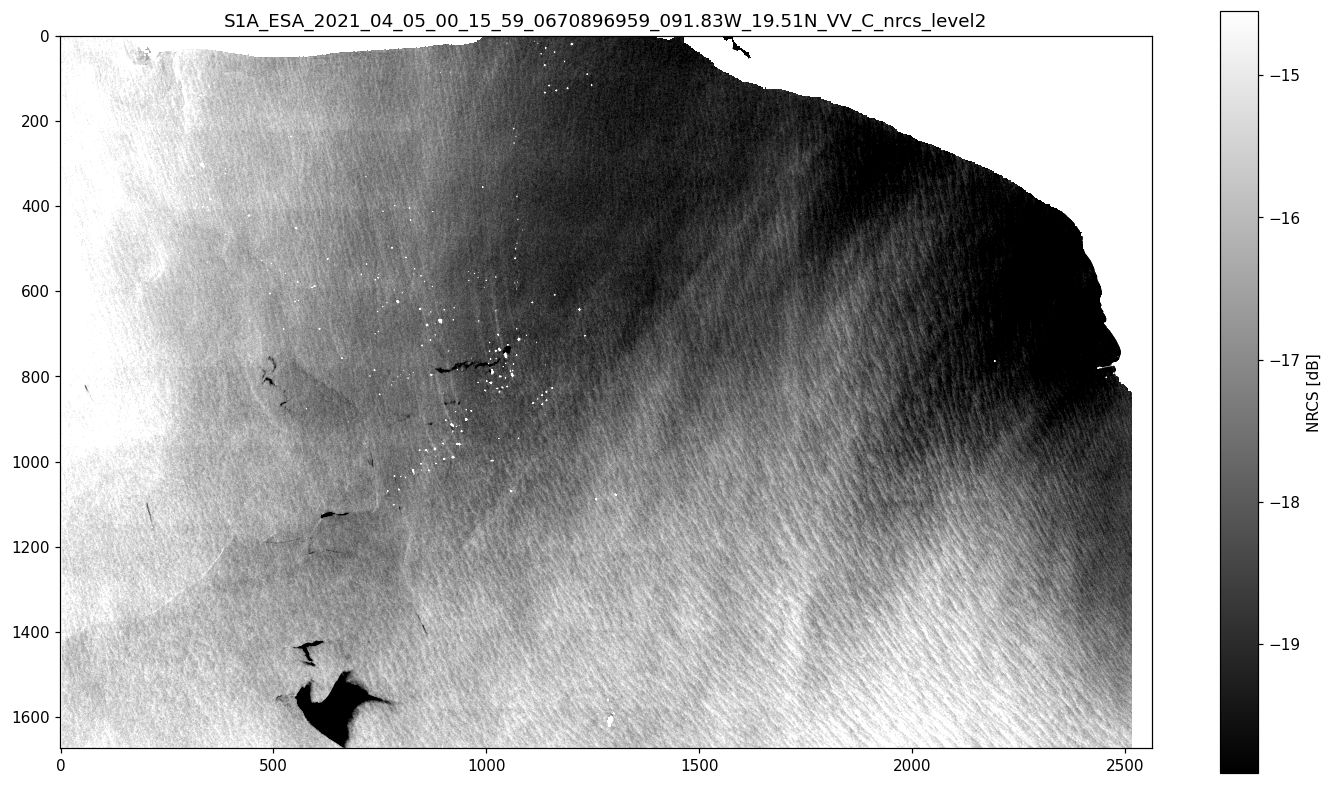

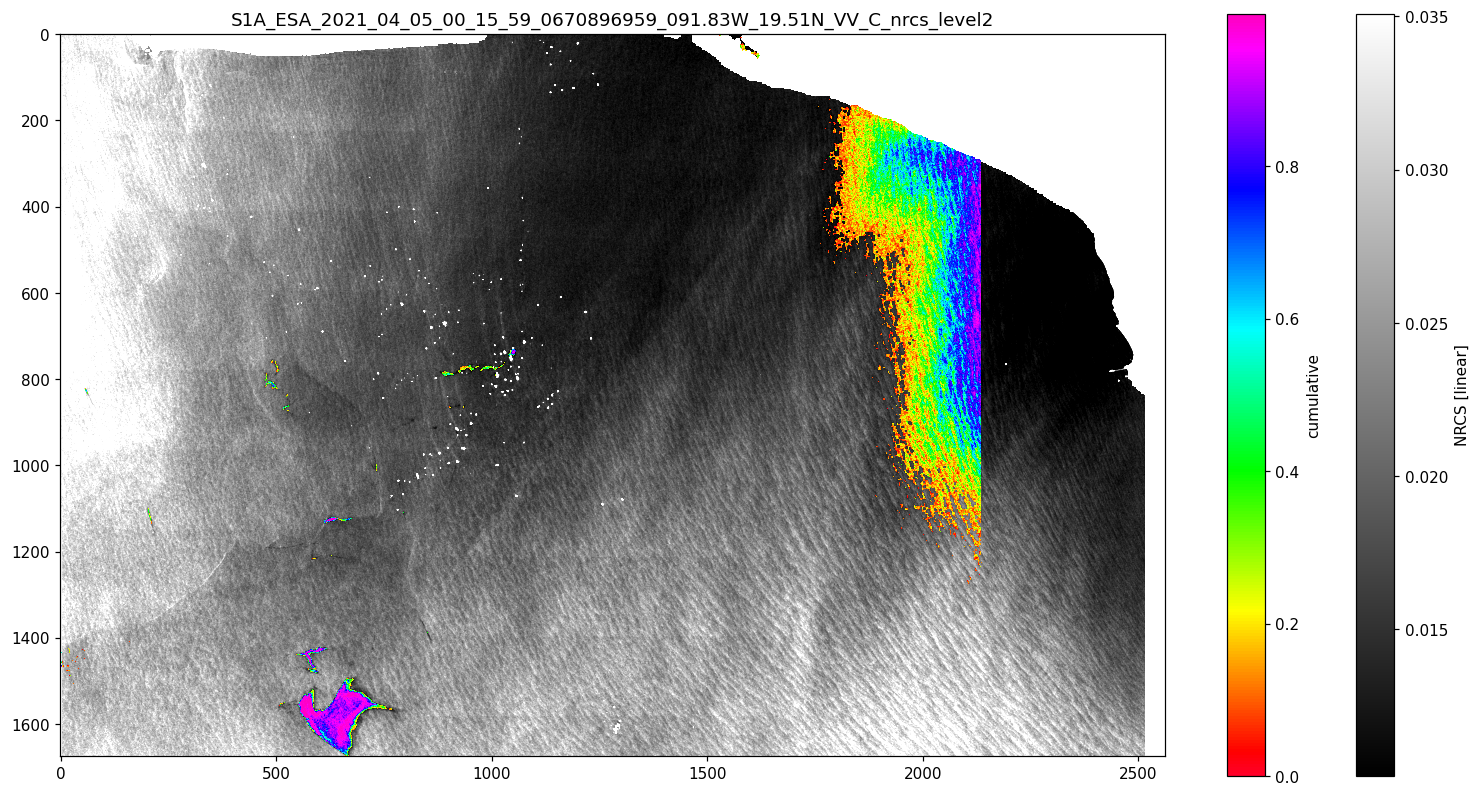

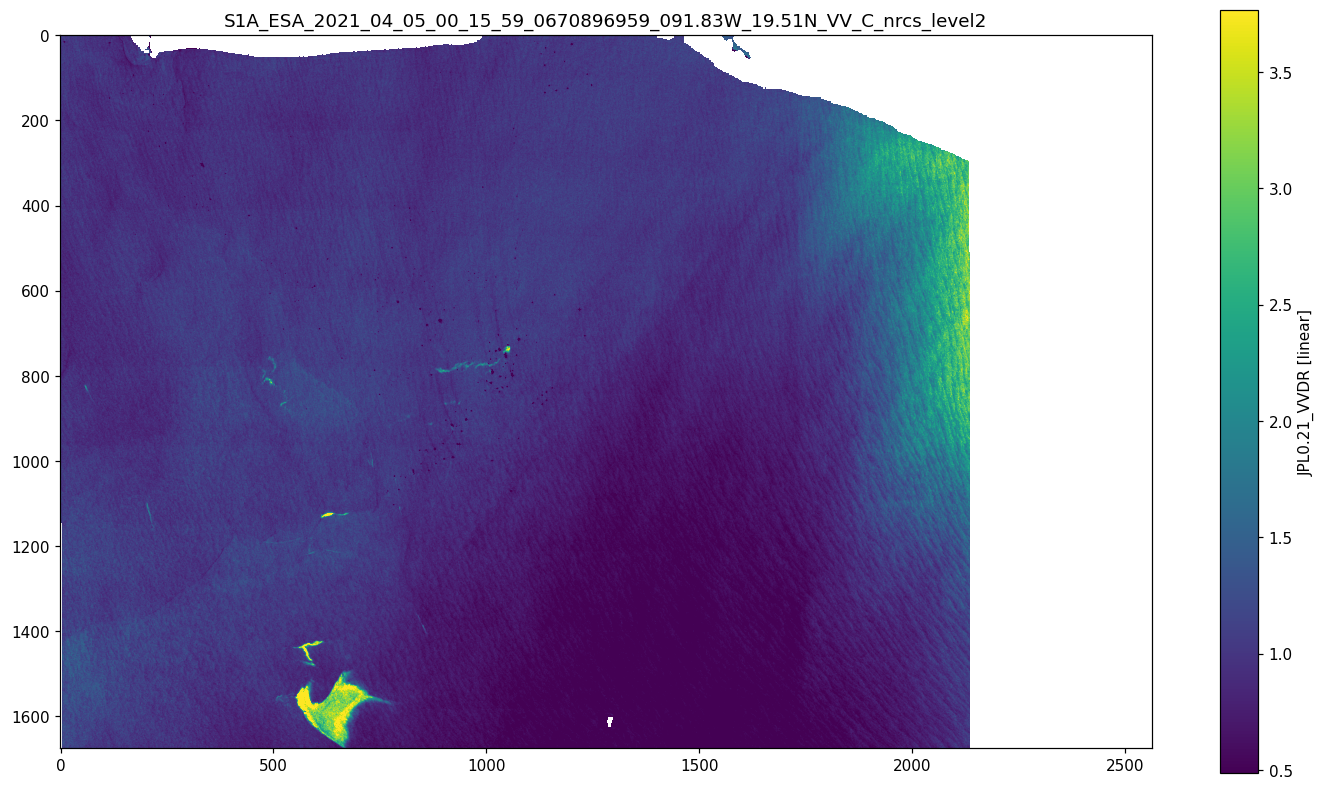

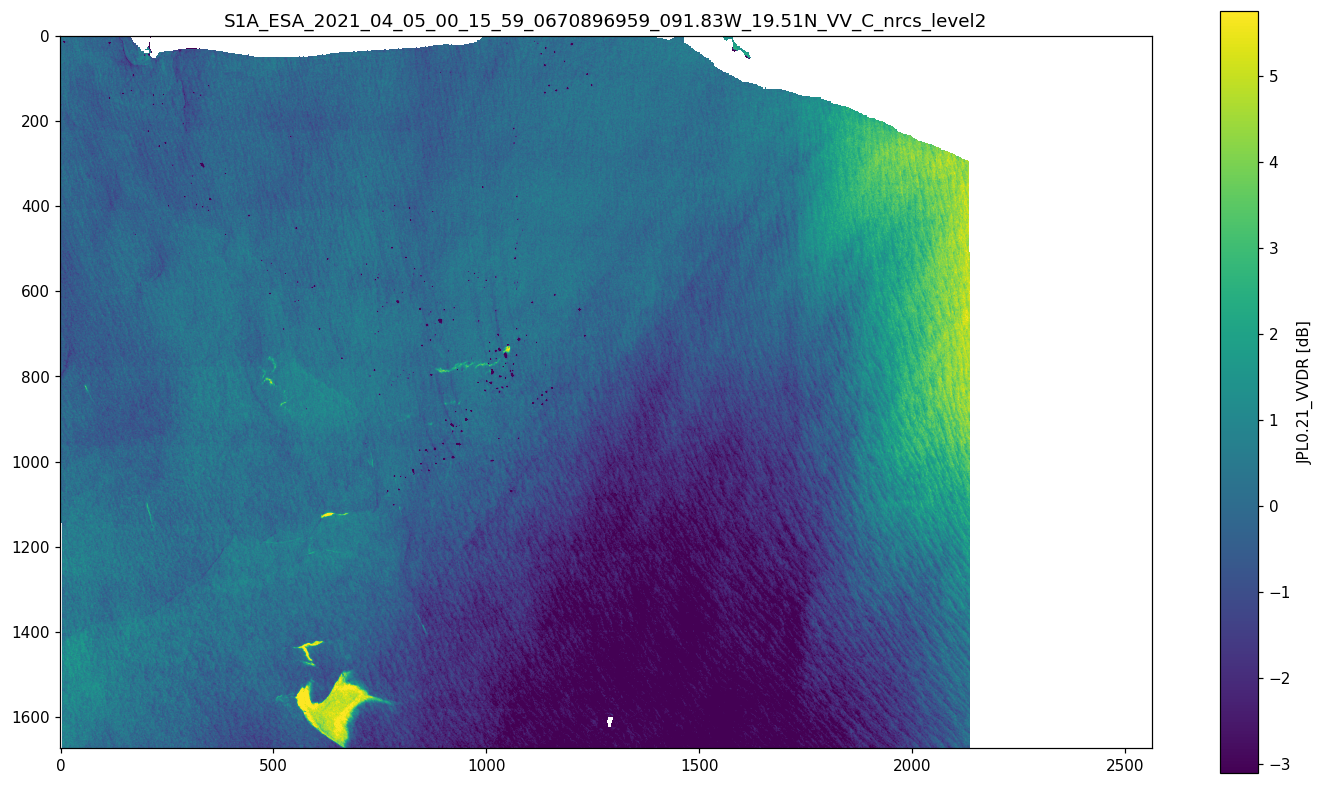

In [12]:
for fileToProcess in FilesToProcess:
    (file_basename, suffix) = path.splitext(basename(fileToProcess))
    if DataFormat == 'ENVI':
        cfgOut['ID'] = 'DR'
        Amp = spectral.open_image(fileToProcess + '.hdr')
        amp = np.ma.masked_invalid(Amp.read_band(0))
    elif DataFormat in ['GEOTIFF','NETCDF']:
        if DataFormat == 'NETCDF':
            with ncfile(fileToProcess) as ds:
                cfgOut['ID'] = f'{versionLabel}_{ds.getncattr("polarization")}DR'
        else:
            cfgOut['ID'] = f'{cfgProc["polarization"]}DR'
        amp = (np.power(10, param * 0.1)) # amp is param in linear units

    status, pfit, fittype, nfitbins = u.fit_xy_from_AOImask(incang, amp, cleanmask,
                                                            Xlabel = f'incidence angle [{angLabel}]',
                                                            Ylabel = 'mean signal',
                                                            Title  = file_basename)
    waterfit = polyval(incang, pfit)

    amp.mask |= landmask
    dampratio = waterfit / amp
    dampratio.mask |= outsideanglims

    DR_minDirty = u.dumb_sigma(dampratio, ratio=100)
    dirtywater = np.ma.masked_less(dampratio, DR_minDirty)
    cumulative = np.ma.masked_array(np.argsort(np.ma.argsort(dirtywater,axis=None),axis=None).reshape(amp.shape))/np.sum(~dirtywater.mask);
    cumulative.mask = dirtywater.mask
    cumulative = u.ma_remove_small(cumulative,area=2)
    cumu_expanded = u.ma_expand(cumulative,2.9)

    figure()
    bins = np.logspace(-1,np.log10(np.amax(dampratio)),1000)
    hist(dampratio[~dampratio.mask],bins)
    hist(dirtywater[~dirtywater.mask],bins)
    title('damping ratio distribution (clean/dirty cut = %.2f)'%DR_minDirty)
    xlabel('damping ratio')
    ylabel('# pixels')
    yscale('log'); xscale('log')
    savefig(abspath(path.join(outdir, f'{file_basename}_{cfgOut["ID"]}_DRHist.png')))

    figure(figsize=(16,9),dpi=110) # db signal amplitude
    clims = np.percentile(param.data[~param.mask], [5,95])
    imshow(param, vmin=clims[0], vmax=clims[1], cmap='gray')
    title(file_basename)
    colorbar(label='NRCS [dB]')
    savefig(abspath(path.join(outdir, f'{file_basename}_{versionLabel}_NRCS_dB.png')))

    figure(figsize=(16,9),dpi=110) # linear signal amplitude
    clims = np.percentile(amp.data[~amp.mask], [5,95])
    imshow(amp, vmin=clims[0], vmax=clims[1], cmap='gray')
    colorbar(label='NRCS [linear]',fraction=.05)
    title(file_basename)
    imshow(cumu_expanded,cmap='gist_rainbow')
    colorbar(label='cumulative', fraction=.05)
    imshow(amp, alpha=0) # transparent overlay
    savefig(abspath(path.join(outdir, f'{file_basename}_{versionLabel}_NRCS_linear+cumul.png')))

    figure(figsize=(16,9),dpi=110) # linear damping ratio
    clims = np.percentile(dampratio.data[~dampratio.mask], [5,99.9])
    imshow(dampratio, vmin=clims[0], vmax=clims[1])
    colorbar(label=f'{cfgOut["ID"]} [linear]')
    title(file_basename)
    savefig(abspath(path.join(outdir, f'{file_basename}_{cfgOut["ID"]}_linear.png')))

    figure(figsize=(16,9),dpi=110) # logarithmic damping ratio (dB)
    imshow((10*np.ma.log10(dampratio)), vmin=10*np.log10(clims[0]), vmax=10*np.log10(clims[1]))
    colorbar(label=f'{cfgOut["ID"]} [dB]')
    title(file_basename)
    savefig(abspath(path.join(outdir, f'{file_basename}_{cfgOut["ID"]}_dB.png')))

    # output format is specified by cfgOut['format'] \in {envi, geotiff, netcdf}
    datadict = {'contrast_ratio': {'data': dampratio,
                                   'long_name': 'Contrast ratio'},
                'cumulative'    : {'data': cumulative,
                                   'long_name': 'Cumulative distribution of the contrast ratio'}}
    u.writedata(datadict, fileToProcess, outdir, cfgOut)

In [13]:
if jj+1 < len(filelist):
    jj += 1
    print("Return to first block below loop index initialization to run next case.")
else:
    print("No more data to process (jj = %d)"%jj)

Return to first block below loop index initialization to run next case.
